In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import re
from pathlib import Path
import enum
import matplotlib.pyplot as plt


In [3]:
class ModelType(str, enum.Enum):
    BADGES = 'Badges'
    COMMENTS = 'Comments'
    POST_HISTORY = 'PostHistory'
    POST_LINKS = 'PostLinks'
    POSTS = 'Posts'
    TAGS = 'Tags'
    USERS = 'Users'
    VOTES = 'Votes'


class ForumType(str, enum.Enum):
    BICYCLES = 'bicycles'
    CODEGOLF = 'codegolf'
    COFFEE = 'coffee'
    CRYPTO = 'crypto'
    GAMEDEV = 'gamedev'
    PETS = 'pets'
    UKRAINIAN = 'ukrainian'

    
def read_stackexchange_csv(name, forum_name, forum_sufix='stackexchange.com', base_path='data'):
    file_path = Path(base_path) / f'{forum_name}.{forum_sufix}' / f'{name}.csv'
    return pd.read_csv(file_path)


def read_stackexchange(model_type, forum_type):
    return read_stackexchange_csv(model_type.value, forum_type.value)


In [4]:
# Assumptions:
#   there are no hard rules as to what constitutes a language name
#   language is usually in <h1>, <h2>, or <h3>
#   we can only be sure that a number represents solution length when it is followed by "bytes" or alike
#   language is at the top-most found header


In [5]:
byte_ex = re.compile(r"\d+\s*(byte|char|character|operation)")  # n bytes
trail_ex = re.compile(r"[\s,-]+$")  # Trailing whitespace and some characters
# This wont count in ex. "C++14 (86 bytes)"
brackets_ex = re.compile(r"\([^\(\)]*\)")
# So we perform a prior subs. with this
pre_brackets_ex = re.compile(r"\([^\(\)]+(byte|char|character|operation)s?\)")


In [6]:
def find_lang(headers):
    """
    :param headers: List of headers as text
    :return: First match or None
    """
    res = []

    # Try to find header with "n bytes" or similar
    for h in headers:
        match = byte_ex.search(h)
        if match:
            res.append(h[:match.start()])

    # Remove trailing whitespace
    res = [trail_ex.sub('', h) for h in res]
    # Assume first match is result
    return res[0] if res else None


In [7]:
def get_headers(soup, level):
    """

    :param soup:
    :param level: h1, h2, or h3
    :return:
    """
    # Extract headers (capitalize and pure text)
    res = [h.get_text(separator=" ").capitalize() for h in soup.find_all(level)]

    # Remove brackets from expressions like "(n bytes)" => "n bytes"
    for i, h in enumerate(res):
        occ = pre_brackets_ex.search(h)
        if occ:
            s, e = occ.span()
            res[i] = ''.join([h[:s], occ.group()[1:-1], h[e:]])

    # Remove things in brackets
    res = [brackets_ex.sub('', h) for h in res]

    return res


In [8]:
def prepare(content):
    soup = BeautifulSoup(content, 'html.parser')
    # remove <strike>, <s>, <del> (people cross out old solutions)
    _extracted = [s.extract() for s in soup(['strike', 's', 'del'])]
    # Prettify to get rid of whitespace
    soup.prettify()
    return soup


In [9]:
def attempt(content):
    soup = prepare(content)

    # Assuming top-most header contains name of language
    for level in ['h1', 'h2', 'h3']:
        h = get_headers(soup, level)
        lang = find_lang(h)
        if lang:
            break

    return lang


In [10]:
def row_gen(posts):
    # PosTypeId == 2 -> Answer
    for body in posts.loc[posts.PostTypeId == 2, "Body"]:
        lang = attempt(body)
        if lang:
            yield lang


In [11]:
posts_df = read_stackexchange(ModelType.POSTS, ForumType.CODEGOLF)


In [12]:
languages = pd.DataFrame(row_gen(posts_df), columns=['Language'])
print(f"Processed {100 * len(languages) / len(posts_df)}% entries")


Processed 73.56549941032387% entries


In [13]:
languages = languages.value_counts().reset_index().rename(columns={0: 'Count'})


In [14]:
languages.head(32)


,Language,Count
0,Javascript,7263
1,Python 2,5420
2,Jelly,4990
3,05ab1e,3978
4,Haskell,3795
5,C,3590
6,Python 3,3507
7,Pyth,3474
8,Ruby,3153
9,Php,2899


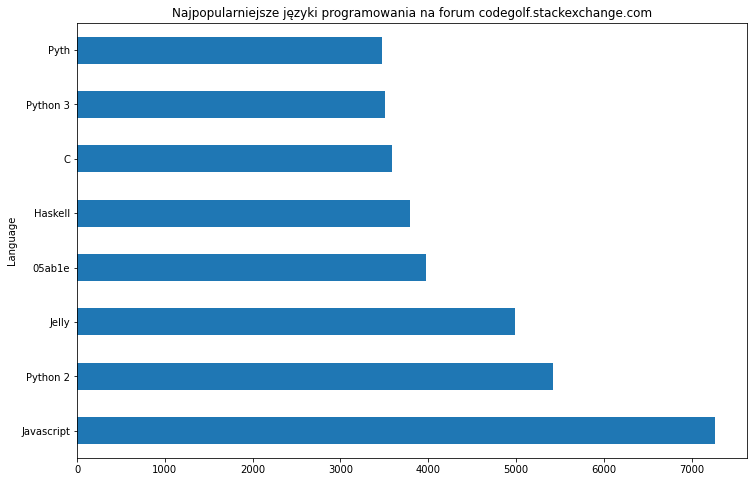

In [15]:
title = f'Najpopularniejsze języki programowania na forum {ForumType.CODEGOLF.value}.stackexchange.com'
plot = languages.head(8).plot.barh(x='Language', y='Count', figsize=(12, 8), title=title,
                                   ylabel='Count', legend = False)
